In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

In [161]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'stroke-prediction-dataset' dataset.
Path to dataset files: /kaggle/input/stroke-prediction-dataset


In [162]:
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
df = pd.read_csv(csv_path)

In [163]:
df.shape

(5110, 12)

In [164]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [165]:
# Check Null and Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [166]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [167]:
df['stroke'].describe()

,stroke
count,5110.000000
mean,0.048728
std,0.215320
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [168]:
df['stroke'].isnull().sum()

np.int64(0)

In [232]:
df.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,201


In [169]:
had_stroke = df[df['stroke'] == 1]['id'].count()
had_no_stroke = df[df['stroke'] == 0]['id'].count()
total = len(df)

stroke_pct = (had_stroke / total * 100)
no_stroke_pct = (had_no_stroke / total * 100)

print(f"\n Stroke Distribution:")
print(f"  • No Stroke (0): {had_no_stroke:,} people ({no_stroke_pct:.2f}%)")
print(f"  • Stroke (1):    {had_stroke:,} people ({stroke_pct:.2f}%)")
print(f"  • Total:         {total:,} people")


 Stroke Distribution:
  • No Stroke (0): 4,861 people (95.13%)
  • Stroke (1):    249 people (4.87%)
  • Total:         5,110 people


In [170]:
df['stroke'].value_counts()

,count
stroke,
0,4861
1,249


In [171]:
df_majority = df[df['stroke'] == 0]
df_minority = df[df['stroke'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,            # sample with replacement
    n_samples=len(df_majority), # match majority class
    random_state=42           # for reproducibility
)

# Combine majority and upsampled minority
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [172]:
print(df_upsampled['stroke'].value_counts())

stroke
0    4861
1    4861
Name: count, dtype: int64


In [173]:
df_upsampled.shape

(9722, 12)

In [174]:
df_upsampled.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
250,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
252,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0


In [175]:
# Handle missing values in BMI column
print("Handling missing values...")
print(f"Missing BMI values: {df_upsampled['bmi'].isnull().sum()}")

# Fill missing BMI with median
df_upsampled['bmi'] = df_upsampled['bmi'].fillna(df_upsampled['bmi'].median())

print(f"After filling: {df_upsampled['bmi'].isnull().sum()}")

# Now create your df_encoded
df_encoded = df_upsampled.drop('id', axis=1)  # Also drop ID column if you haven't

# Then continue with your existing code
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

Handling missing values...
Missing BMI values: 972
After filling: 0


In [176]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [177]:
X = preprocessor.fit_transform(X)

In [178]:
X.shape

(9722, 21)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((7777, 21), (1945, 21))

In [233]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
history_random_forest = random_forest.fit(X_train, y_train)

In [181]:
rf_pred = random_forest.predict(X_test)

#model evaluation
print(f"Accuracy: {random_forest.score(X_test, y_test):.3f}")
print(f"Precision: {precision_score(y_test, rf_pred):.3f}")
print(f"Recall: {recall_score(y_test, rf_pred):.3f}")

Accuracy: 0.987
Precision: 0.973
Recall: 1.000


MODEL COMPARISON: Random Forest vs SVM

✓ SVM Results:
   Accuracy:  0.846
   Precision: 0.794
   Recall:    0.925

DETAILED COMPARISON

Random Forest - Classification Report:
              precision    recall  f1-score   support

   No Stroke       1.00      0.97      0.99       993
      Stroke       0.97      1.00      0.99       952

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945


SVM - Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.91      0.77      0.84       993
      Stroke       0.79      0.93      0.85       952

    accuracy                           0.85      1945
   macro avg       0.85      0.85      0.85      1945
weighted avg       0.86      0.85      0.85      1945



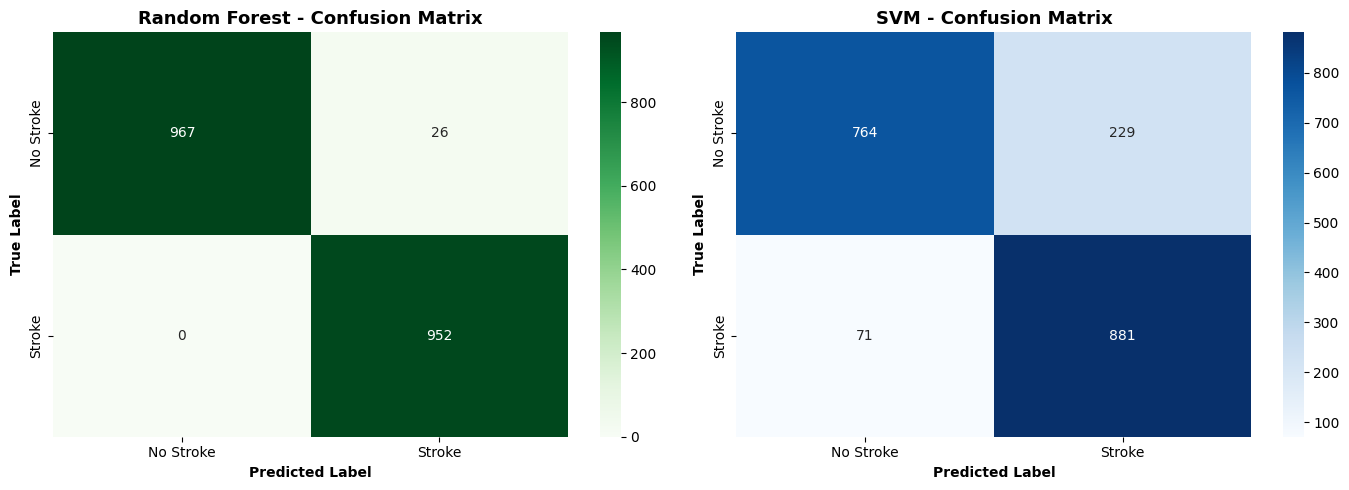


 SUMMARY

         Model  Accuracy  Precision  Recall
Random Forest  0.986632   0.973415 1.00000
          SVM  0.845758   0.793694 0.92542

 Winner: Random Forest (by 14.09% accuracy)


In [182]:
# Add this import at the top with your other imports
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import time

df_upsampled['bmi'] = df_upsampled['bmi'].fillna(df_upsampled['bmi'].median())

# Now proceed with encoding
df_encoded = df_upsampled.drop('id', axis=1)  # Remove ID column

print("="*60)
print("MODEL COMPARISON: Random Forest vs SVM")
print("="*60)

# SVM with RBF kernel (most common for classification)
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
history_svm = svm_model.fit(X_train, y_train)

# SVM Predictions
svm_pred = svm_model.predict(X_test)

print(f"\n✓ SVM Results:")
print(f"   Accuracy:  {svm_model.score(X_test, y_test):.3f}")
print(f"   Precision: {precision_score(y_test, svm_pred):.3f}")
print(f"   Recall:    {recall_score(y_test, svm_pred):.3f}")

# ==================== DETAILED COMPARISON ====================
print("\n" + "="*60)
print("DETAILED COMPARISON")
print("="*60)

print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, rf_pred, target_names=['No Stroke', 'Stroke']))

print("\nSVM - Classification Report:")
print(classification_report(y_test, svm_pred, target_names=['No Stroke', 'Stroke']))

rf_cm = confusion_matrix(y_test, rf_pred)
svm_cm = confusion_matrix(y_test, svm_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot confusion matrices
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
axes[0].set_title('Random Forest - Confusion Matrix', fontweight='bold', fontsize=13)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
axes[1].set_title('SVM - Confusion Matrix', fontweight='bold', fontsize=13)
axes[1].set_ylabel('True Label', fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.show()

# ==================== SUMMARY ====================
print("\n" + "="*60)
print(" SUMMARY")
print("="*60)

models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'SVM'],
    'Accuracy': [random_forest.score(X_test, y_test),
                 svm_model.score(X_test, y_test)],
    'Precision': [precision_score(y_test, rf_pred),
                  precision_score(y_test, svm_pred)],
    'Recall': [recall_score(y_test, rf_pred),
               recall_score(y_test, svm_pred)]
})

print("\n", models_comparison.to_string(index=False))

# Determine winner
if random_forest.score(X_test, y_test) > svm_model.score(X_test, y_test):
    print(f"\n Winner: Random Forest (by {(random_forest.score(X_test, y_test) - svm_model.score(X_test, y_test))*100:.2f}% accuracy)")
elif svm_model.score(X_test, y_test) > random_forest.score(X_test, y_test):
    print(f"\n Winner: SVM (by {(svm_model.score(X_test, y_test) - random_forest.score(X_test, y_test))*100:.2f}% accuracy)")
else:
    print("\n Tie: Both models perform equally well!")

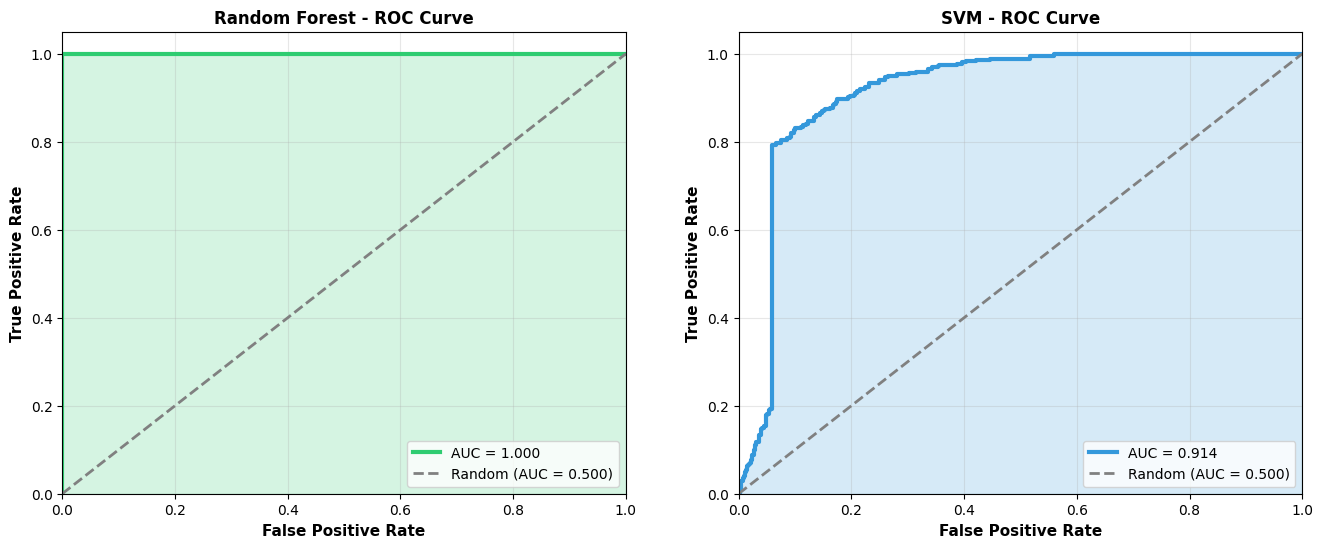

In [183]:
#ROC curves fir both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

rf_pred_prob = random_forest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_prob)
auc_rf = auc(fpr_rf, tpr_rf)

svm_pred_prob = svm_model.decision_function(X_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred_prob)
auc_svm = auc(fpr_svm, tpr_svm)

# Random Forest
axes[0].plot(fpr_rf, tpr_rf, color='#2ecc71', lw=3, label=f'AUC = {auc_rf:.3f}')
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[0].fill_between(fpr_rf, tpr_rf, alpha=0.2, color='#2ecc71')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[0].set_title('Random Forest - ROC Curve', fontweight='bold', fontsize=12)
axes[0].legend(loc="lower right", fontsize=10)
axes[0].grid(True, alpha=0.3)

# SVM
axes[1].plot(fpr_svm, tpr_svm, color='#3498db', lw=3, label=f'AUC = {auc_svm:.3f}')
axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[1].fill_between(fpr_svm, tpr_svm, alpha=0.2, color='#3498db')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[1].set_title('SVM - ROC Curve', fontweight='bold', fontsize=12)
axes[1].legend(loc="lower right", fontsize=10)
axes[1].grid(True, alpha=0.3)

In [184]:
NN_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [185]:
NN_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)

In [186]:
NN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [187]:
history = NN_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7579 - loss: 0.5078 - val_accuracy: 0.7924 - val_loss: 0.4534
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8028 - loss: 0.4266 - val_accuracy: 0.8168 - val_loss: 0.4169
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8171 - loss: 0.3973 - val_accuracy: 0.8297 - val_loss: 0.3933
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8423 - loss: 0.3561 - val_accuracy: 0.8483 - val_loss: 0.3449
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8652 - loss: 0.3273 - val_accuracy: 0.8856 - val_loss: 0.3040
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8869 - loss: 0.2747 - val_accuracy: 0.9113 - val_loss: 0.2870
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8957 - loss: 0.2656 - val_accuracy: 0.8978 - val_loss: 0.2750
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9061 - loss: 0.2447 - val_accuracy: 0.

In [231]:
#evaluate the NN model
loss, accuracy = NN_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

#find recall and precision
y_pred = (NN_model.predict(X_test) > 0.5).astype(int)
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9226 - loss: 0.2190
Test Loss: 0.2452
Test Accuracy: 0.9172
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Precision: 0.8686
Recall: 0.9790


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Text(0.5, 1.0, 'Confusion Matrix for NN Model')

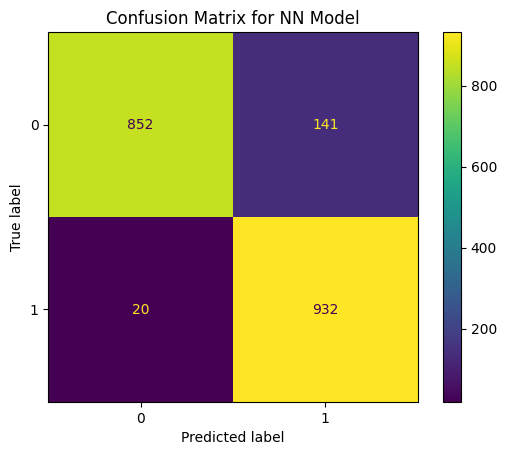

In [189]:
# confusion matrix for nn model
y_pred_nn = (NN_model.predict(X_test) > 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn)
plt.title('Confusion Matrix for NN Model')

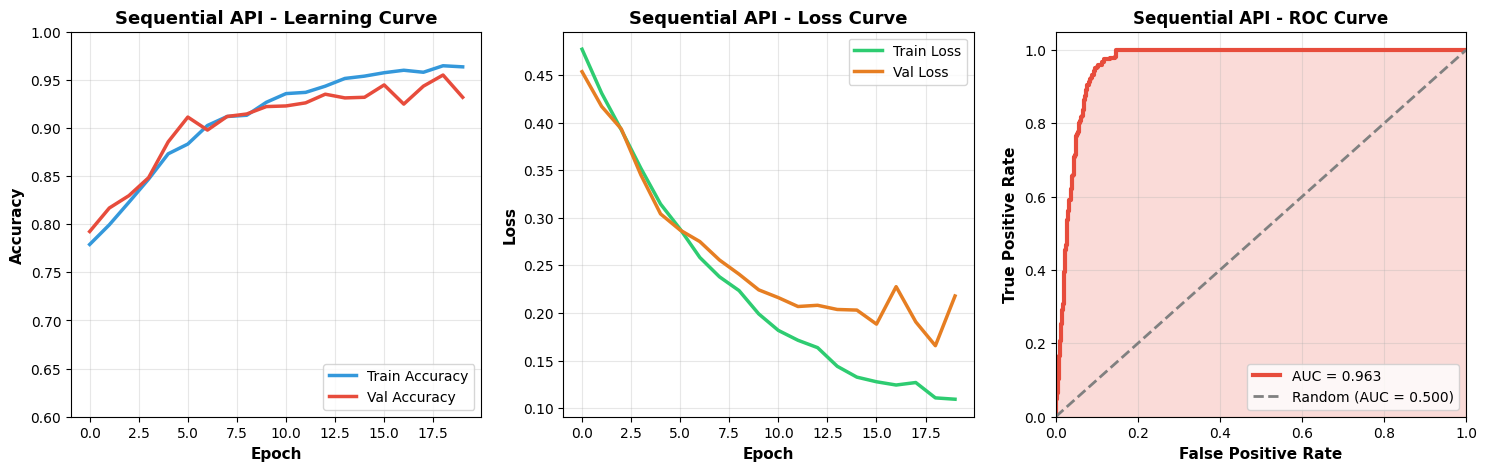

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Learning curve of Sequential model
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#3498db')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#e74c3c')
axes[0].set_title('Sequential API - Learning Curve', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=11)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

# Loss curve of Sequential model
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2.5, color='#2ecc71')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2.5, color='#e67e22')
axes[1].set_title('Sequential API - Loss Curve', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Loss', fontweight='bold', fontsize=11)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# ROC curve of Sequential model
nn_pred_prob = NN_model.predict(X_test, verbose=0).flatten()
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_pred_prob)
auc_nn = auc(fpr_nn, tpr_nn)
axes[2].plot(fpr_nn, tpr_nn, color='#e74c3c', lw=3, label=f'AUC = {auc_nn:.3f}')
axes[2].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[2].fill_between(fpr_nn, tpr_nn, alpha=0.2, color='#e74c3c')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_title('Sequential API - ROC Curve', fontweight='bold', fontsize=12)
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(True, alpha=0.3)

In [191]:
# Build model using Functional API (different from Sequential)
functional_input = tf.keras.layers.Input(shape=(X_train.shape[1],), name='input_layer')

# First block
x = tf.keras.layers.Dense(128, activation='relu', name='dense1')(functional_input)
x = tf.keras.layers.BatchNormalization(name='bn1')(x)
x = tf.keras.layers.Dropout(0.3, name='dropout1')(x)

# Second block
x = tf.keras.layers.Dense(64, activation='relu', name='dense2')(x)
x = tf.keras.layers.BatchNormalization(name='bn2')(x)
x = tf.keras.layers.Dropout(0.3, name='dropout2')(x)

# Third block
x = tf.keras.layers.Dense(32, activation='relu', name='dense3')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout3')(x)

# Output
functional_output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

# Create model
functional_model = tf.keras.Model(inputs=functional_input, outputs=functional_output,
                         name='Functional_API_Model')


In [192]:
functional_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [193]:
functional_model.summary()

Model: "Functional_API_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,953 (54.50 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [194]:
functional_history = functional_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6441 - loss: 0.6636 - precision_9: 0.6616 - recall_7: 0.5609 - val_accuracy: 0.7776 - val_loss: 0.5479 - val_precision_9: 0.7361 - val_recall_7: 0.8584
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7538 - loss: 0.5004 - precision_9: 0.7406 - recall_7: 0.8061 - val_accuracy: 0.7886 - val_loss: 0.5020 - val_precision_9: 0.7739 - val_recall_7: 0.8091
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7680 - loss: 0.4754 - precision_9: 0.7469 - recall_7: 0.8128 - val_accuracy: 0.7860 - val_loss: 0.4596 - val_precision_9: 0.7298 - val_recall_7: 0.9013
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7805 - loss: 0.4554 - precision_9: 0.7477 - recall_7: 0.8532 - val_accuracy: 0.7943 - val_loss: 0.4302 - val_precision_9: 0.7383 - val_recall_7: 0.9052
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7826 - loss: 0.4439 - precision_9: 0.7511 - recall_7: 0.8547 - val_accur

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Text(0.5, 1.0, 'Confusion Matrix for NN Model')

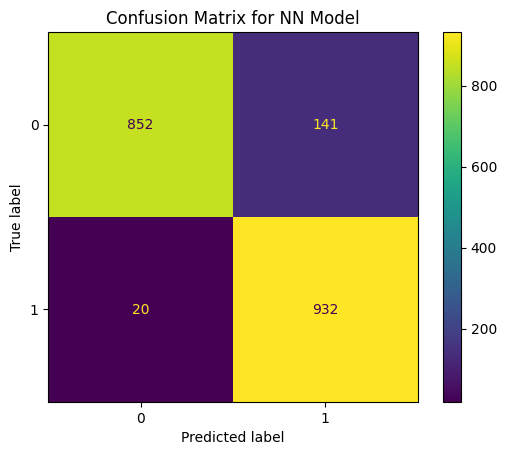

In [225]:
y_pred_fn = (functional_model.predict(X_test) > 0.5).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_nn)
plt.title('Confusion Matrix for NN Model')

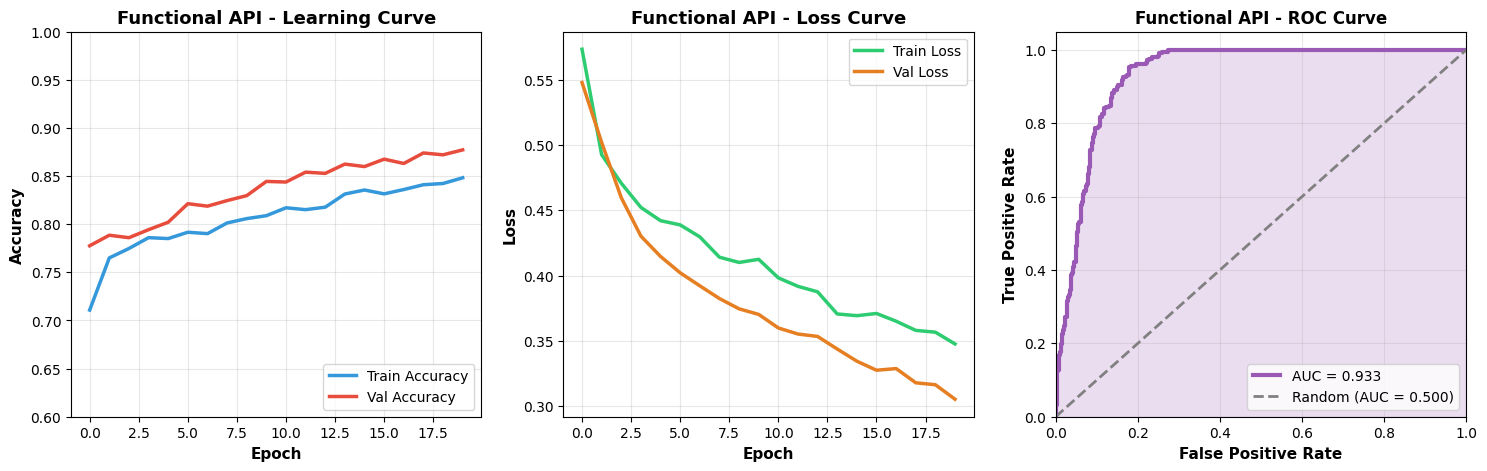

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Learning Curve for Functional API model
axes[0].plot(functional_history.history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#3498db')
axes[0].plot(functional_history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#e74c3c')
axes[0].set_title('Functional API - Learning Curve', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=11)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

# Loss Curve for Functional API model
axes[1].plot(functional_history.history['loss'], label='Train Loss', linewidth=2.5, color='#2ecc71')
axes[1].plot(functional_history.history['val_loss'], label='Val Loss', linewidth=2.5, color='#e67e22')
axes[1].set_title('Functional API - Loss Curve', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Loss', fontweight='bold', fontsize=11)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# ROC Curve for Functional API model
functional_pred_prob = functional_model.predict(X_test, verbose=0).flatten()
fpr_func, tpr_func, _ = roc_curve(y_test, functional_pred_prob)
auc_func = auc(fpr_func, tpr_func)

axes[2].plot(fpr_func, tpr_func, color='#9b59b6', lw=3, label=f'AUC = {auc_func:.3f}')
axes[2].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[2].fill_between(fpr_func, tpr_func, alpha=0.2, color='#9b59b6')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_title('Functional API - ROC Curve', fontweight='bold', fontsize=12)
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(True, alpha=0.3)


In [197]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Split training data for validation
val_size = int(0.2 * len(X_train))
X_train_split = X_train[val_size:]
y_train_split = y_train.iloc[val_size:].values if hasattr(y_train, 'iloc') else y_train[val_size:]
X_val_split = X_train[:val_size]
y_val_split = y_train.iloc[:val_size].values if hasattr(y_train, 'iloc') else y_train[:val_size]

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_split, y_train_split))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_split, y_val_split))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test.values if hasattr(y_test, 'values') else y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [198]:
print("\n✓ Created tf.data pipelines:")
print(f"  - Training samples: {len(X_train_split)}")
print(f"  - Validation samples: {len(X_val_split)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Using tf.data.AUTOTUNE for optimization")


✓ Created tf.data pipelines:
  - Training samples: 6222
  - Validation samples: 1555
  - Test samples: 1945
  - Batch size: 64
  - Using tf.data.AUTOTUNE for optimization


In [199]:
# Build model for tf.data
tfdata_input = tf.keras.layers.Input(shape=(X_train.shape[1],))
x = tf.keras.layers.Dense(128, activation='relu')(tfdata_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
tfdata_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


In [200]:
tfdata_model = tf.keras.Model(tfdata_input, tfdata_output, name='TF_Data_Model')
tfdata_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [201]:
tfdata_history = tfdata_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6677 - loss: 0.6209 - precision_10: 0.6681 - recall_8: 0.6876 - val_accuracy: 0.7659 - val_loss: 0.5498 - val_precision_10: 0.7632 - val_recall_8: 0.7490
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7685 - loss: 0.4948 - precision_10: 0.7496 - recall_8: 0.8105 - val_accuracy: 0.7794 - val_loss: 0.4893 - val_precision_10: 0.7435 - val_recall_8: 0.8313
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7820 - loss: 0.4756 - precision_10: 0.7602 - recall_8: 0.8283 - val_accuracy: 0.7910 - val_loss: 0.4631 - val_precision_10: 0.7352 - val_recall_8: 0.8884
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7814 - loss: 0.4637 - precision_10: 0.7534 - recall_8: 0.8424 - val_accuracy: 0.7916 - val_loss: 0.4392 - val_precision_10: 0.7365 - val_recall_8: 0.8871
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7975 - loss: 0.4336 - precision_10: 0.7640 - recall_8: 0.8638 -

In [202]:
# Make predictions on test set
y_pred_tfdata = tfdata_model.predict(test_dataset, verbose=0)
y_pred_tfdata_classes = (y_pred_tfdata > 0.5).astype(int).flatten()

# Get test accuracy and other metrics
test_results = tfdata_model.evaluate(test_dataset, verbose=0)
print(f"\nTest Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")


Test Accuracy: 0.8740
Test Precision: 0.8061
Test Recall: 0.9779


Text(0.5, 1.0, 'tf.data API Model - Confusion Matrix')

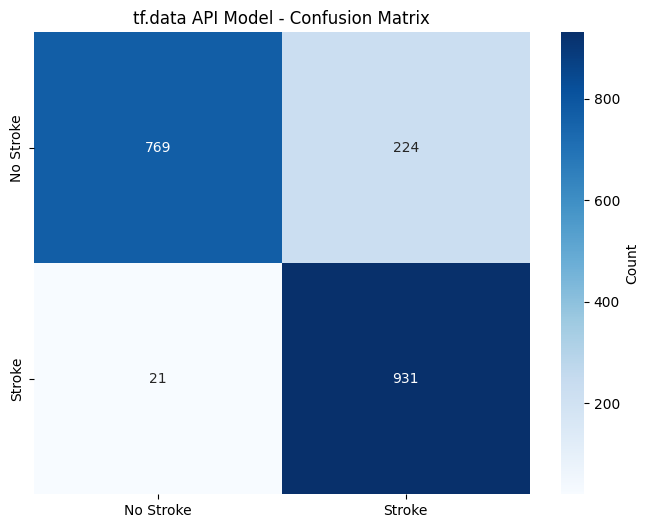

In [203]:
cm_tfdata = confusion_matrix(y_test, y_pred_tfdata_classes)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_tfdata, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            cbar_kws={'label': 'Count'})
ax.set_title('tf.data API Model - Confusion Matrix')


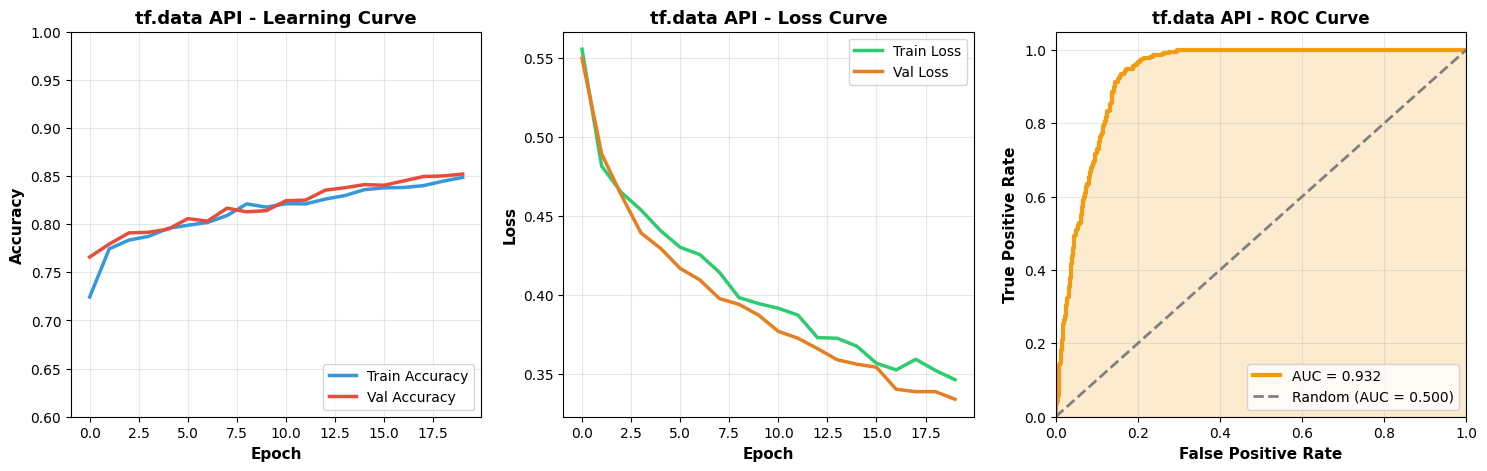

In [204]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Learning Curve for tf.data API model
axes[0].plot(tfdata_history.history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#3498db')
axes[0].plot(tfdata_history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#e74c3c')
axes[0].set_title('tf.data API - Learning Curve', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=11)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

# Loss Curve for tf.data API model
axes[1].plot(tfdata_history.history['loss'], label='Train Loss', linewidth=2.5, color='#2ecc71')
axes[1].plot(tfdata_history.history['val_loss'], label='Val Loss', linewidth=2.5, color='#e67e22')
axes[1].set_title('tf.data API - Loss Curve', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Loss', fontweight='bold', fontsize=11)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# ROC Curve for tf.data API model
tfdata_pred_prob = tfdata_model.predict(test_dataset, verbose=0).flatten()
fpr_tfdata, tpr_tfdata, _ = roc_curve(y_test, tfdata_pred_prob)
auc_tfdata = auc(fpr_tfdata, tpr_tfdata)

axes[2].plot(fpr_tfdata, tpr_tfdata, color='#f39c12', lw=3, label=f'AUC = {auc_tfdata:.3f}')
axes[2].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[2].fill_between(fpr_tfdata, tpr_tfdata, alpha=0.2, color='#f39c12')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_title('tf.data API - ROC Curve', fontweight='bold', fontsize=12)
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(True, alpha=0.3)


In [205]:
l1_input = tf.keras.layers.Input(shape=(X_train.shape[1],), name='l1_input')

# L1 regularization encourages sparse feature selection
x = tf.keras.layers.Dense(256, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1(0.001),
                name='l1_dense1')(l1_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(128, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1(0.001),
                name='l1_dense2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(64, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1(0.001),
                name='l1_dense3')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(32, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1(0.001),
                name='l1_dense4')(x)

l1_output = tf.keras.layers.Dense(1, activation='sigmoid', name='l1_output')(x)
l1_model = tf.keras.Model(l1_input, l1_output, name='L1_Regularization_Model')

In [206]:
l1_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
l1_model.summary()

Model: "L1_Regularization_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ l1_input (InputLayer)           │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_dense1 (Dense)               │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_dense2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_dense3 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_dense4 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l1_output (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,433 (197.00 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 768 (3.00 KB)

In [207]:
l1_history = l1_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ],
    verbose=1
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7295 - loss: 3.6542 - precision_11: 0.7096 - recall_9: 0.7886 - val_accuracy: 0.7847 - val_loss: 2.7022 - val_precision_11: 0.7311 - val_recall_9: 0.8935 - learning_rate: 0.0010
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7922 - loss: 2.3632 - precision_11: 0.7570 - recall_9: 0.8650 - val_accuracy: 0.8085 - val_loss: 1.7413 - val_precision_11: 0.7713 - val_recall_9: 0.8714 - learning_rate: 0.0010
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7816 - loss: 1.5762 - precision_11: 0.7429 - recall_9: 0.8648 - val_accuracy: 0.8091 - val_loss: 1.2007 - val_precision_11: 0.7590 - val_recall_9: 0.9000 - learning_rate: 0.0010
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8115 - loss: 1.1134 - precision_11: 0.7754 - recall_9: 0.8914 - val_accuracy: 0.8188 - val_loss: 0.9481 - val_precision_11: 0.7480 - val_recall_9: 0.9558 - learning_rate: 0.0010
Epoch 5/20
195/195 ━━━━━

  Accuracy:  0.8607
  Precision: 0.8032
  Recall:    0.9475
  Loss:      0.4431


Text(0.5, 1.0, 'l1 Model - Confusion Matrix')

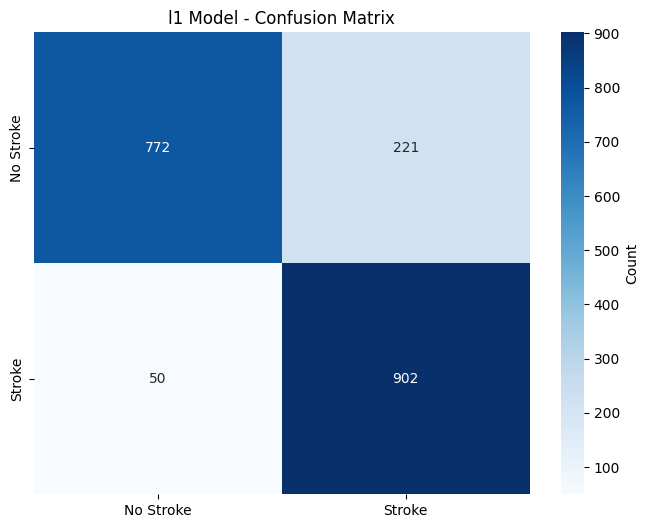

In [221]:
l1_results = l1_model.evaluate(X_test, y_test, verbose=0)
l1_pred_prob = l1_model.predict(X_test, verbose=0).flatten()
l1_pred = (l1_pred_prob > 0.5).astype(int)

print(f"  Accuracy:  {l1_results[1]:.4f}")
print(f"  Precision: {l1_results[2]:.4f}")
print(f"  Recall:    {l1_results[3]:.4f}")
print(f"  Loss:      {l1_results[0]:.4f}")

cm_l1 = confusion_matrix(y_test, l1_pred)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_l1, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            cbar_kws={'label': 'Count'})
ax.set_title('l1 Model - Confusion Matrix')


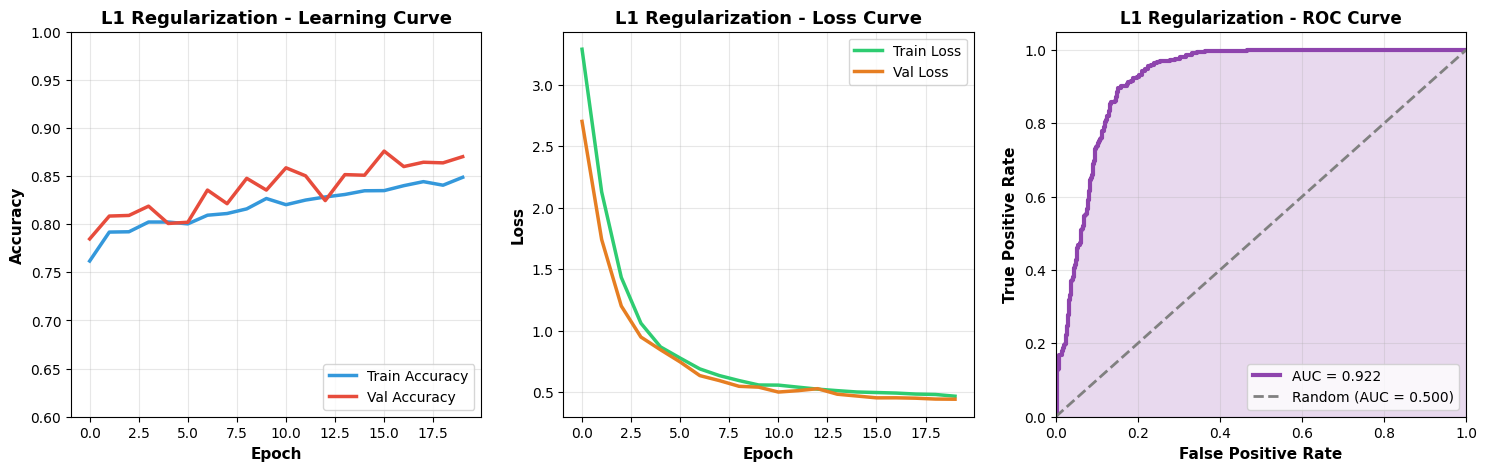

In [222]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Learning Curve for L1 Regularization model
axes[0].plot(l1_history.history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#3498db')
axes[0].plot(l1_history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#e74c3c')
axes[0].set_title('L1 Regularization - Learning Curve', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=11)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

# Loss Curve for L1 Regularization model
axes[1].plot(l1_history.history['loss'], label='Train Loss', linewidth=2.5, color='#2ecc71')
axes[1].plot(l1_history.history['val_loss'], label='Val Loss', linewidth=2.5, color='#e67e22')
axes[1].set_title('L1 Regularization - Loss Curve', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Loss', fontweight='bold', fontsize=11)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# ROC Curve for L1 Regularization model
fpr_l1, tpr_l1, _ = roc_curve(y_test, l1_pred_prob)
auc_l1 = auc(fpr_l1, tpr_l1)

axes[2].plot(fpr_l1, tpr_l1, color='#8e44ad', lw=3, label=f'AUC = {auc_l1:.3f}')
axes[2].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[2].fill_between(fpr_l1, tpr_l1, alpha=0.2, color='#8e44ad')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_title('L1 Regularization - ROC Curve', fontweight='bold', fontsize=12)
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(True, alpha=0.3)

In [210]:
# Build Elastic Net model
elastic_input = tf.keras.layers.Input(shape=(X_train.shape[1],), name='elastic_input')

# Elastic Net = L1 + L2 combined
x = tf.keras.layers.Dense(128, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.001),
                name='elastic_dense1')(elastic_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Dense(128, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.001),
                name='elastic_dense2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Dense(64, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.001),
                name='elastic_dense3')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Dense(32, activation='relu',
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.0005, l2=0.001),
                name='elastic_dense4')(x)

elastic_output = tf.keras.layers.Dense(1, activation='sigmoid', name='elastic_output')(x)

elastic_model = tf.keras.Model(elastic_input, elastic_output, name='Elastic_Net_Model')


In [211]:
elastic_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [212]:
elastic_model.summary()

Model: "Elastic_Net_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ elastic_input (InputLayer)      │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elastic_dense1 (Dense)          │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elastic_dense2 (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elastic_dense3 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elastic_dense4 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elastic_output (Dense)          │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,977 (121.00 KB)

 Trainable params: 30,337 (118.50 KB)

 Non-trainable params: 640 (2.50 KB)

In [213]:
elastic_history = elastic_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    ],
    verbose=1
)

Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6506 - loss: 2.1460 - precision_12: 0.6604 - recall_10: 0.5991 - val_accuracy: 0.7699 - val_loss: 2.0396 - val_precision_12: 0.7390 - val_recall_10: 0.8273 - learning_rate: 5.0000e-04
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7673 - loss: 1.9309 - precision_12: 0.7387 - recall_10: 0.8222 - val_accuracy: 0.7789 - val_loss: 1.8759 - val_precision_12: 0.7426 - val_recall_10: 0.8468 - learning_rate: 5.0000e-04
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7795 - loss: 1.8029 - precision_12: 0.7417 - recall_10: 0.8471 - val_accuracy: 0.7789 - val_loss: 1.7474 - val_precision_12: 0.7139 - val_recall_10: 0.9234 - learning_rate: 5.0000e-04
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7770 - loss: 1.7104 - precision_12: 0.7388 - recall_10: 0.8593 - val_accuracy: 0.7911 - val_loss: 1.6257 - val_precision_12: 0.7330 - val_recall_10: 0.9091 - learning_rate: 5.0000e-04
Epoch 5

  Accuracy:  0.8704
  Precision: 0.8017
  Recall:    0.9769
  Loss:      0.6986


Text(0.5, 1.0, 'Elastic Net - Confusion Matrix')

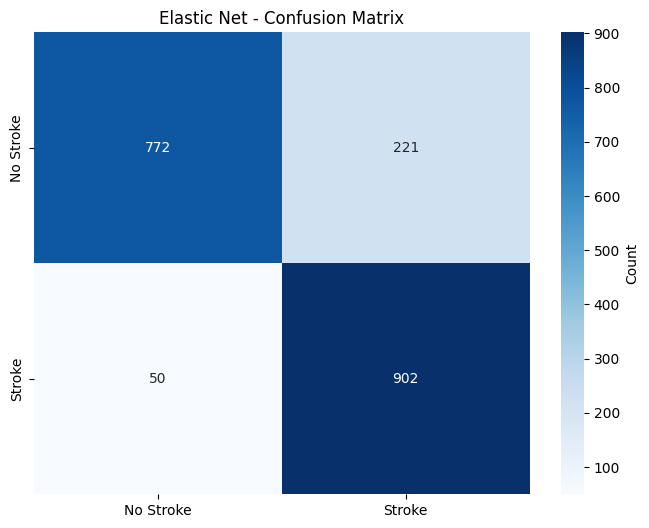

In [223]:
elastic_results = elastic_model.evaluate(X_test, y_test, verbose=0)
elastic_pred_prob = elastic_model.predict(X_test, verbose=0).flatten()
elastic_pred = (elastic_pred_prob > 0.5).astype(int)

print(f"  Accuracy:  {elastic_results[1]:.4f}")
print(f"  Precision: {elastic_results[2]:.4f}")
print(f"  Recall:    {elastic_results[3]:.4f}")
print(f"  Loss:      {elastic_results[0]:.4f}")

cm_elastic = confusion_matrix(y_test, l1_pred)

# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_elastic, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            cbar_kws={'label': 'Count'})
ax.set_title('Elastic Net - Confusion Matrix')

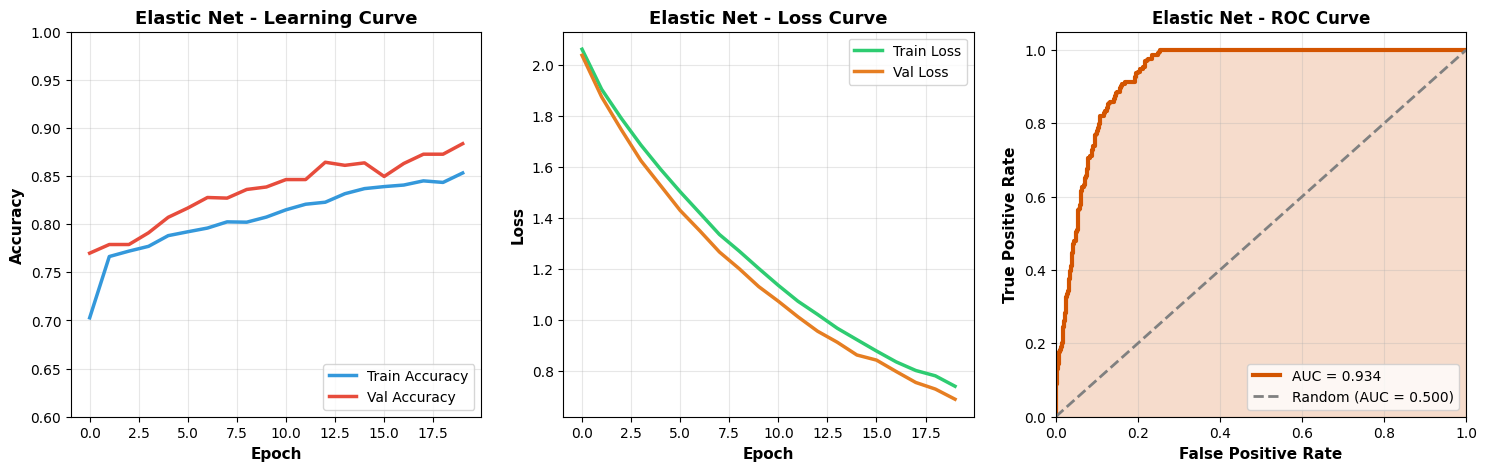

In [224]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Learning Curve for Elastic Net model
axes[0].plot(elastic_history.history['accuracy'], label='Train Accuracy', linewidth=2.5, color='#3498db')
axes[0].plot(elastic_history.history['val_accuracy'], label='Val Accuracy', linewidth=2.5, color='#e74c3c')
axes[0].set_title('Elastic Net - Learning Curve', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=11)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

# Loss Curve for Elastic Net model
axes[1].plot(elastic_history.history['loss'], label='Train Loss', linewidth=2.5, color='#2ecc71')
axes[1].plot(elastic_history.history['val_loss'], label='Val Loss', linewidth=2.5, color='#e67e22')
axes[1].set_title('Elastic Net - Loss Curve', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Epoch', fontweight='bold', fontsize=11)
axes[1].set_ylabel('Loss', fontweight='bold', fontsize=11)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)

# ROC Curve for Elastic Net model
fpr_elastic, tpr_elastic, _ = roc_curve(y_test, elastic_pred_prob)
auc_elastic = auc(fpr_elastic, tpr_elastic)

axes[2].plot(fpr_elastic, tpr_elastic, color='#d35400', lw=3, label=f'AUC = {auc_elastic:.3f}')
axes[2].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random (AUC = 0.500)')
axes[2].fill_between(fpr_elastic, tpr_elastic, alpha=0.2, color='#d35400')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[2].set_title('Elastic Net - ROC Curve', fontweight='bold', fontsize=12)
axes[2].legend(loc="lower right", fontsize=10)
axes[2].grid(True, alpha=0.3)